## FEATURES

* dataset mas grande (2000 datos)
* Mas variables (piscina, parrillero, año de construcción, etc.)

In [1]:
# imports

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import numpy as np
import pandas
from sklearn.metrics import mean_absolute_error

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
folder = '/content/drive/MyDrive/MaestriaDataScience/Tesis/FINAL_DATASET_CLEAN.xlsx'

In [4]:

import pandas as pd

data = pd.read_excel(folder)

In [5]:
data.head()

,Unnamed: 0,url,precio,Baños,Superficie,Superficie Construida,Superficie Terreno,Garage,Calefacción,Cocina,...,Plantas,Parrillero,Acepta Mascotas,Patio,Dormitorio,barrio,municipio,precio_por_m2_construido,precio_por_m2_terreno,precio_por_m2
0,0,https://www.casasymas.com.uy/propiedad/186603-...,675000,4.0,NaN,242,268,2,0,NaN,...,3.0,1,NaN,0,4.0,parque-batlle,CH,2789.256198,2518.656716,NaN
1,2,https://www.casasymas.com.uy/propiedad/212637-...,148000,2.0,131.0,98,131,1,0,Cocina Integrada,...,NaN,0,Acepta Mascotas,0,2.0,belvedere,A,1510.204082,1129.770992,1129.770992
2,3,https://www.casasymas.com.uy/propiedad/225135-...,625000,3.0,408.0,234,174,1,0,Cocina Definida,...,NaN,0,Acepta Mascotas,0,4.0,carrasco,E,2670.940171,3591.954023,1531.862745
3,4,https://www.casasymas.com.uy/propiedad/225720-...,580000,2.0,285.0,156,201,0,0,NaN,...,NaN,0,NaN,0,3.0,carrasco,E,3717.948718,2885.572139,2035.087719
4,6,https://www.casasymas.com.uy/propiedad/186448-...,670000,4.0,NaN,249,321,2,0,NaN,...,2.0,0,Acepta Mascotas,0,4.0,pocitos,CH,2690.763052,2087.227414,NaN


## Funciones Auxiliares

Para automatizar entrenamiento de modelos y ahorrar tiempo. Luego invocaremos las funciones para entrenar.

In [6]:
def split_data_log(df, features: list, target: list):
  X = features
  y = np.log(target)
  X = X.fillna(0)
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
  return X_train, X_test, y_train, y_test

In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

def split_data_with_preprocessing(
    df,
    target: str,
    num_cols: list,
    cat_cols: list,
    test_size: float = 0.20,
    random_state: int = 42
):
    # Transformación logarítmica del target
    y = np.log(df[target])

    # Features sin target
    X = df[num_cols + cat_cols]

    # División simple: train vs test
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )

    # Pipelines
    numeric_transformer = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ])

    categorical_transformer = Pipeline(steps=[
        ("encoder", OneHotEncoder(handle_unknown="ignore"))
    ])

    # Preprocesador combinado
    preprocess = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, num_cols),
            ("cat", categorical_transformer, cat_cols)
        ]
    )

    # Ajustar preprocess SOLO en training
    preprocess.fit(X_train)

    # Transformar datos
    X_train_prep = preprocess.transform(X_train)
    X_test_prep = preprocess.transform(X_test)

    return (
        X_train_prep, X_test_prep,
        y_train, y_test,
        preprocess,
        X_test.index
    )


In [8]:
def linear_regression_model(X_train, y_train):
  model_lr = LinearRegression()
  model_lr.fit(X_train, y_train)
  return model_lr

In [9]:
import lightgbm as lgb

def lightgbm_model(X_train, y_train, params=None):

    # Parámetros por defecto optimizados para MAE

    if params is None:
        params = {
            "objective": "l1",
            "metric": "mae",
            "learning_rate": 0.03,
            "num_leaves": 31,
            "feature_fraction": 0.9,
            "bagging_fraction": 0.8,
            "bagging_freq": 5
        }

    train_data = lgb.Dataset(X_train, label=y_train)

    model = lgb.train(
        params=params,
        train_set=train_data,
        num_boost_round=500
    )

    return model

In [10]:
from xgboost import XGBRegressor

def train_xgboost(X_train, y_train):
    model = XGBRegressor(
        n_estimators=600,
        learning_rate=0.05,
        max_depth=4,
        min_child_weight=1,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=1.0,
        reg_alpha=0.01,
        objective="reg:absoluteerror",
        random_state=42,
        tree_method="hist"
    )

    model.fit(X_train, y_train)
    return model


In [11]:
from sklearn.model_selection import GridSearchCV

def train_xgboost_gridsearch(X_train, y_train, cv_folds=5, n_jobs=-1):

    param_grid = {
        "n_estimators": [600, 900, 1200],
        "learning_rate": [0.01, 0.03, 0.05],
        "max_depth": [3, 4, 5],
        "min_child_weight": [1, 3, 5],
        "subsample": [0.7, 0.85, 1.0],
        "colsample_bytree": [0.6, 0.8, 1.0],
        "reg_lambda": [1.0, 2.0, 5.0],
        "reg_alpha": [0, 0.01, 0.1]
    }

    xgb = XGBRegressor(
        objective="reg:absoluteerror",
        tree_method="hist",
        random_state=42
    )

    grid = GridSearchCV(
        estimator=xgb,
        param_grid=param_grid,
        scoring="neg_mean_absolute_error",  # optimizar MAE
        cv=cv_folds,
        verbose=1,
        n_jobs=n_jobs
    )

    grid.fit(X_train, y_train)

    print("\n======== MEJORES PARÁMETROS XGBOOST ========")
    print(grid.best_params_)
    print("\nMejor MAE (en log-space):", -grid.best_score_)
    print("=============================================\n")

    # Modelo final con los mejores hiperparámetros
    best_model = grid.best_estimator_

    return best_model


In [12]:
from sklearn.ensemble import RandomForestRegressor

def train_random_forest(X_train, y_train):
    rf = RandomForestRegressor(
        n_estimators=600,
        max_depth=20,
        min_samples_split=5,
        min_samples_leaf=2,
        max_features="sqrt",
        bootstrap=True,
        n_jobs=-1,
        random_state=42
    )

    rf.fit(X_train, y_train)
    return rf

In [13]:
def evaluate_model(model, X_test, y_test):
    y_test_pred_log = model.predict(X_test)

    y_test_pred_real = np.exp(y_test_pred_log)
    y_test_real = np.exp(y_test)

    mse_real = mean_squared_error(y_test_real, y_test_pred_real)
    r2_real = r2_score(y_test_real, y_test_pred_real)
    mae_real = mean_absolute_error(y_test_real, y_test_pred_real)
    medae_real = np.median(np.abs(y_test_real - y_test_pred_real))

    # MAPE — Mean Absolute Percentage Error
    mape = 100 * np.mean(np.abs((y_test_real - y_test_pred_real) / y_test_real))

    # MdAPE — Median Absolute Percentage Error
    mdape = 100 * np.median(np.abs((y_test_real - y_test_pred_real) / y_test_real))

    return mse_real, r2_real, mae_real, medae_real, mape, mdape

In [14]:
def crear_tabla_resultados(nombres, mse_list, r2_list, mae_list, medae_list, mape_list, mdape_list):
    resultados = []

    for nombre, mse, r2, mae, medae, mape, mdape in zip(nombres, mse_list, r2_list, mae_list, medae_list, mape_list, mdape_list):
        resultados.append({
            "Modelo": nombre,
            "MAE": mae,
            "MEDAE": medae,
            "MSE": mse,
            "R2": r2,
            "MAPE": mape,
            "MDAPE": mdape
        })

    df_resultados = pd.DataFrame(resultados)
    pd.options.display.float_format = '{:,.2f}'.format
    return df_resultados


In [15]:
def evaluation_table(model, X_test_prep, y_test, df_original, extra_cols=None):

    # Predicción en log
    y_pred_log = model.predict(X_test_prep)

    # Convertir a precio real
    y_pred_real = np.exp(y_pred_log)
    y_test_real = np.exp(y_test)

    # Tabla base
    results = pd.DataFrame({
        "Precio Real": y_test_real,
        "Precio Predicho": y_pred_real,
    })

    results["Error Absoluto"] = np.abs(results["Precio Real"] - results["Precio Predicho"])
    results["Error %"] = 100 * results["Error Absoluto"] / results["Precio Real"]

    # Agregar columnas originales
    if extra_cols:
        df_extra = df_original.reset_index(drop=True)[extra_cols]
        results = pd.concat([results, df_extra], axis=1)

    return results.sort_values(by="Error %", ascending=False).reset_index(drop=True)


## Target y Features

In [16]:
features = ["Baños", "Dormitorio", "Superficie", "Superficie Construida", "Superficie Terreno", "Garage", "Parrillero", "Calefacción", "Año de Construcción", "Jardín", "Piscina", "Patio"]



target = "precio"

## Train Test Splits

In [17]:
cat_cols = ["barrio", "municipio"]

(
    X_train_prep_all_municipios,
    X_test_prep_all_municipios,
    y_train_all_municipios,
    y_test_all_municipios,
    preprocess_all_municipios,
    test_indices_all_municipios
) = split_data_with_preprocessing(
        df=data,
        target=target,
        num_cols=features,
        cat_cols=cat_cols,
        test_size=0.20,
        random_state=42
    )


In [18]:
data_ch = data[data["municipio"] == "CH"].copy()

cat_cols = ["barrio", "municipio"]

(
    X_train_prep_ch,
    X_test_prep_ch,
    y_train_ch,
    y_test_ch,
    preprocess_ch,
    test_indices_ch
) = split_data_with_preprocessing(
        df=data_ch,             # ← ahora solo CH
        target=target,
        num_cols=features,
        cat_cols=cat_cols,      # podés incluir categóricas o dejarlas vacías
        test_size=0.20,
        random_state=42
    )


In [19]:
data_e = data[data["municipio"] == "E"].copy()

cat_cols = ["barrio", "municipio"]

(
    X_train_prep_e,
    X_test_prep_e,
    y_train_e,
    y_test_e,
    preprocess_e,
    test_indices_e
) = split_data_with_preprocessing(
        df=data_e,
        target=target,
        num_cols=features,
        cat_cols=cat_cols,
        test_size=0.20,
        random_state=42
    )


## Modelos

Entrenamos los siguientes modelos:

* XGB
* XGB CH
* XGB E
* LGBM
* LGBM CH
* LGBM E
* LR
* LR CH
* LR E
* RF
* RF CH
* RF E

Nombres de modelos:

* `xgb`
* `model_lgbm`
* `lgbm_ch`
* `lgbm_e`
* `model_lr`
* `model_lr_ch`
* `model_lr_e`
* `rf_all_municipios`
* `rf_municipio_ch`
* `rf_municipio_e`

## `xgb`

In [20]:
xgb = train_xgboost(
    X_train_prep_all_municipios,
    y_train_all_municipios
)


In [21]:
mse_xgb, r2_xgb, mae_xgb, medae_xgb, mape_xgb, mdape_xgb = evaluate_model(
    xgb,
    X_test_prep_all_municipios,
    y_test_all_municipios
)

print(f"Mean Squared Error (MSE): {mse_xgb}")
print(f"R² Score: {r2_xgb}")
print(f"Mean Absolute Error (MAE): {mae_xgb}")
print(f"Median Absolute Error (XGB): {medae_xgb}")
print(f"MAPE (XGB): {mape_xgb}")
print(f"Median Absolute Percentage Error (XGB): {mdape_xgb}")


Mean Squared Error (MSE): 26743363939.47731
R² Score: 0.7576433426451425
Mean Absolute Error (MAE): 84311.13773354095
Median Absolute Error (XGB): 41679.35937499994
MAPE (XGB): 20.414921854135336
Median Absolute Percentage Error (XGB): 15.87452806122445


## `xgb_ch`

In [22]:
xgb_ch = train_xgboost(
    X_train_prep_ch,
    y_train_ch
)

print("XGBoost simple entrenado:", xgb_ch)

XGBoost simple entrenado: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
             max_leaves=None, min_child_weight=1, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=600,
             n_jobs=None, num_parallel_tree=None, ...)


In [23]:
mse_xgb_ch, r2_xgb_ch, mae_xgb_ch, medae_xgb_ch, mape_xgb_ch, mdape_xgb_ch = evaluate_model(
    xgb_ch,
    X_test_prep_ch,
    y_test_ch
)

print(f"Mean Squared Error (MSE): {mse_xgb_ch}")
print(f"R² Score: {r2_xgb_ch}")
print(f"Mean Absolute Error (MAE): {mae_xgb_ch}")
print(f"Median Absolute Error (XGB): {medae_xgb_ch}")
print(f"MAPE (XGB): {mape_xgb_ch}")
print(f"Median Absolute Percentage Error (XGB): {mdape_xgb_ch}")


Mean Squared Error (MSE): 44131720053.51197
R² Score: 0.5723169209551748
Mean Absolute Error (MAE): 117790.39699074079
Median Absolute Error (XGB): 49286.671874999985
MAPE (XGB): 21.862803944149555
Median Absolute Percentage Error (XGB): 17.33380920794023


## `xgb_e`

In [24]:
xgb_e = train_xgboost(
    X_train_prep_e,
    y_train_e
)

print("XGBoost simple entrenado:", xgb_e)

XGBoost simple entrenado: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
             max_leaves=None, min_child_weight=1, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=600,
             n_jobs=None, num_parallel_tree=None, ...)


In [25]:
mse_xgb_e, r2_xgb_e, mae_xgb_e, medae_xgb_e, mape_xgb_e, mdape_xgb_e = evaluate_model(
    xgb_e,
    X_test_prep_e,
    y_test_e
)

print(f"Mean Squared Error (MSE): {mse_xgb_e}")
print(f"R² Score: {r2_xgb_e}")
print(f"Mean Absolute Error (MAE): {mae_xgb_e}")
print(f"Median Absolute Error (XGB): {medae_xgb_e}")
print(f"MAPE (XGB): {mape_xgb_e}")
print(f"Median Absolute Percentage Error (XGB): {mdape_xgb_e}")


Mean Squared Error (MSE): 27148926954.689285
R² Score: 0.7661127320690939
Mean Absolute Error (MAE): 113279.79119318185
Median Absolute Error (XGB): 76731.96875
MAPE (XGB): 20.355580931555195
Median Absolute Percentage Error (XGB): 13.988936642156895


## `model_lgbm` (all municipios)

In [26]:
model_lgbm = lightgbm_model(
    X_train_prep_all_municipios,
    y_train_all_municipios
)

print("Modelo LightGBM entrenado:", model_lgbm)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000260 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 920
[LightGBM] [Info] Number of data points in the train set: 1124, number of used features: 35
[LightGBM] [Info] Start training from score 12.611538
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

In [27]:
mse_lgbm, r2_lgbm, mae_lgbm, medae_lgbm, mape_lgbm, mdape_lgbm = evaluate_model(
    model_lgbm,
    X_test_prep_all_municipios,
    y_test_all_municipios
)

print(f"Mean Squared Error (LGBM): {mse_lgbm}")
print(f"R² Score (LGBM): {r2_lgbm}")
print(f"Mean Absolute Error (LGBM): {mae_lgbm}")
print(f"Median Absolute Error (LGBM): {medae_lgbm}")
print(f"MAPE (LGBM): {mape_lgbm}")
print(f"Median Absolute Percentage Error (LGBM): {mdape_lgbm}")

Mean Squared Error (LGBM): 27247058353.28235
R² Score (LGBM): 0.7530787076674947
Mean Absolute Error (LGBM): 88330.39126173545
Median Absolute Error (LGBM): 47796.38027181529
MAPE (LGBM): 21.687258364107986
Median Absolute Percentage Error (LGBM): 15.632019720097693


## `lgbm_ch`

In [28]:
# Modelo CH simple
lgbm_ch = lightgbm_model(
    X_train_prep_ch,
    y_train_ch
)

print("Modelo LightGBM CH simple entrenado:", lgbm_ch)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000037 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 240
[LightGBM] [Info] Number of data points in the train set: 214, number of used features: 15
[LightGBM] [Info] Start training from score 12.676076
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

In [29]:
mse_lgbm_ch, r2_lgbm_ch, mae_lgbm_ch, medae_lgbm_ch, mape_lgbm_ch, mdape_lgbm_ch = evaluate_model(
    lgbm_ch,
    X_test_prep_ch,
    y_test_ch
)

print(f"Mean Squared Error (LGBM CH simple): {mse_lgbm_ch}")
print(f"R² Score (LGBM CH simple): {r2_lgbm_ch}")
print(f"Mean Absolute Error (LGBM CH simple): {mae_lgbm_ch}")
print(f"Median Absolute Error (LGBM CH simple): {medae_lgbm_ch}")
print(f"MAPE (LGBM CH simple): {mape_lgbm_ch}")
print(f"Median Absolute Percentage Error (LGBM CH simple): {mdape_lgbm_ch}")

Mean Squared Error (LGBM CH simple): 55049676636.765816
R² Score (LGBM CH simple): 0.46651036542682
Mean Absolute Error (LGBM CH simple): 130328.14389393128
Median Absolute Error (LGBM CH simple): 67161.9402121843
MAPE (LGBM CH simple): 24.073612030718632
Median Absolute Percentage Error (LGBM CH simple): 15.868053248780923


## `lgbm_e`

In [30]:
# Modelo E simple
lgbm_e = lightgbm_model(
    X_train_prep_e,
    y_train_e
)

print("Modelo LightGBM E simple entrenado:", lgbm_e)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000065 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 415
[LightGBM] [Info] Number of data points in the train set: 438, number of used features: 17
[LightGBM] [Info] Start training from score 13.217091
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

In [31]:
mse_lgbm_e, r2_lgbm_e, mae_lgbm_e, medae_lgbm_e, mape_lgbm_e, mdape_lgbm_e = evaluate_model(
    lgbm_e,
    X_test_prep_e,
    y_test_e
)

print(f"Mean Squared Error (LGBM E simple): {mse_lgbm_e}")
print(f"R² Score (LGBM E simple): {r2_lgbm_e}")
print(f"Mean Absolute Error (LGBM E simple): {mae_lgbm_e}")
print(f"Median Absolute Error (LGBM E simple): {medae_lgbm_e}")
print(f"MAPE (LGBM E simple): {mape_lgbm_e}")
print(f"Median Absolute Percentage Error (LGBM E simple): {mdape_lgbm_e}")


Mean Squared Error (LGBM E simple): 26133646451.812435
R² Score (LGBM E simple): 0.7748593460106945
Mean Absolute Error (LGBM E simple): 113146.90748407702
Median Absolute Error (LGBM E simple): 81872.53656288033
MAPE (LGBM E simple): 21.669937317700512
Median Absolute Percentage Error (LGBM E simple): 15.579207148035099


## `model_lr`

Todos los municipios, features simples

In [32]:
model_lr = linear_regression_model(X_train_prep_all_municipios, y_train_all_municipios)

print("Modelo entrenado:", model_lr)

Modelo entrenado: LinearRegression()


In [33]:
mse_lr, r2_lr, mae_lr, medae_lr, mape_lr, mdape_lr  = evaluate_model(model_lr, X_test_prep_all_municipios, y_test_all_municipios)

print(f"Mean Squared Error (Real): {mse_lr}")
print(f"R² Score (Real): {r2_lr}")
print(f"Mean Absolute Error (Real): {mae_lr}")
print(f"Median Absolute Error (Real): {medae_lr}")
print(f"MAPE: {mape_lr}")
print(f"Median Absolute Percentage Error (%): {mdape_lr}")

Mean Squared Error (Real): 24667822059.934772
R² Score (Real): 0.776452546800025
Mean Absolute Error (Real): 93786.09667742052
Median Absolute Error (Real): 53963.889416567865
MAPE: 23.822897617593654
Median Absolute Percentage Error (%): 19.20251141832411


## `model_lr_ch`

In [34]:
model_lr_ch = linear_regression_model(X_train_prep_ch, y_train_ch)

print("Modelo entrenado:", model_lr_ch)

Modelo entrenado: LinearRegression()


In [35]:
mse_lr_ch, r2_lr_ch, mae_lr_ch, medae_lr_ch, mape_lr_ch, mdape_lr_ch  = evaluate_model(model_lr_ch, X_test_prep_ch, y_test_ch)

print(f"Mean Squared Error (Real): {mse_lr_ch}")
print(f"R² Score (Real): {r2_lr_ch}")
print(f"Mean Absolute Error (Real): {mae_lr_ch}")
print(f"Median Absolute Error (Real): {medae_lr_ch}")
print(f"MAPE: {mape_lr_ch}")
print(f"Median Absolute Percentage Error (%): {mdape_lr_ch}")

Mean Squared Error (Real): 24336503368.508526
R² Score (Real): 0.7641535231074639
Mean Absolute Error (Real): 98973.14917840778
Median Absolute Error (Real): 54554.83765190086
MAPE: 20.741546538075927
Median Absolute Percentage Error (%): 14.254525038606602


## `model_lr_e`

In [36]:
model_lr_e = linear_regression_model(X_train_prep_e, y_train_e)

print("Modelo entrenado:", model_lr_e)

Modelo entrenado: LinearRegression()


In [37]:
mse_lr_e, r2_lr_e, mae_lr_e, medae_lr_e, mape_lr_e, mdape_lr_e  = evaluate_model(model_lr_e, X_test_prep_e, y_test_e)

print(f"Mean Squared Error (Real): {mse_lr_e}")
print(f"R² Score (Real): {r2_lr_e}")
print(f"Mean Absolute Error (Real): {mae_lr_e}")
print(f"Median Absolute Error (Real): {medae_lr_e}")
print(f"MAPE: {mape_lr_e}")
print(f"Median Absolute Percentage Error (%): {mdape_lr_e}")

Mean Squared Error (Real): 23029960067.314095
R² Score (Real): 0.8015975198691382
Mean Absolute Error (Real): 117729.84043507517
Median Absolute Error (Real): 101936.49392584998
MAPE: 22.459626430984475
Median Absolute Percentage Error (%): 17.30971332347836


## `rf_all_municipios`

In [38]:
rf_all_municipios = train_random_forest(X_train_prep_all_municipios, y_train_all_municipios)

print("Modelo entrenado:", rf_all_municipios)

Modelo entrenado: RandomForestRegressor(max_depth=20, max_features='sqrt', min_samples_leaf=2,
                      min_samples_split=5, n_estimators=600, n_jobs=-1,
                      random_state=42)


In [39]:
mse_rf_all_municipios, r2_rf_all_municipios, mae_rf_all_municipios, medae_rf_all_municipios, mape_rf_all_municipios, mdape_rf_all_municipios = evaluate_model(rf_all_municipios, X_test_prep_all_municipios, y_test_all_municipios)

print(f"Mean Squared Error (Real): {mse_rf_all_municipios}")
print(f"R² Score (Real): {r2_rf_all_municipios}")
print(f"Mean Absolute Error (Real): {mae_rf_all_municipios}")
print(f"Median Absolute Error (Real): {medae_rf_all_municipios}")
print(f"MAPE: {mape_rf_all_municipios}")
print(f"Median Absolute Percentage Error (%): {mdape_rf_all_municipios}")

Mean Squared Error (Real): 34601526949.24538
R² Score (Real): 0.6864302325701728
Mean Absolute Error (Real): 96349.98108208521
Median Absolute Error (Real): 51341.07380862156
MAPE: 23.48184222859338
Median Absolute Percentage Error (%): 18.761833382401548


## `rf_municipio_ch`

In [40]:
rf_municipio_ch = train_random_forest(X_train_prep_ch, y_train_ch)

print("Modelo entrenado:", rf_municipio_ch)

Modelo entrenado: RandomForestRegressor(max_depth=20, max_features='sqrt', min_samples_leaf=2,
                      min_samples_split=5, n_estimators=600, n_jobs=-1,
                      random_state=42)


In [41]:
mse_rf_municipio_ch, r2_rf_municipio_ch, mae_rf_municipio_ch, medae_rf_municipio_ch, mape_rf_municipio_ch, mdape_rf_municipio_ch = evaluate_model(rf_municipio_ch, X_test_prep_ch, y_test_ch)

print(f"Mean Squared Error (Real): {mse_rf_municipio_ch}")
print(f"R² Score (Real): {r2_rf_municipio_ch}")
print(f"Mean Absolute Error (Real): {mae_rf_municipio_ch}")
print(f"Median Absolute Error (Real): {medae_rf_municipio_ch}")
print(f"MAPE: {mape_rf_municipio_ch}")
print(f"Median Absolute Percentage Error (%): {mdape_rf_municipio_ch}")

Mean Squared Error (Real): 51775895437.36828
R² Score (Real): 0.498236770420318
Mean Absolute Error (Real): 119208.27869252978
Median Absolute Error (Real): 52384.93512731642
MAPE: 21.21959523433652
Median Absolute Percentage Error (%): 14.222847503493524


## `rf_municipio_e`

municipio e y features simples

In [42]:
rf_municipio_e = train_random_forest(X_train_prep_e, y_train_e)

print("Modelo entrenado:", rf_municipio_e)

Modelo entrenado: RandomForestRegressor(max_depth=20, max_features='sqrt', min_samples_leaf=2,
                      min_samples_split=5, n_estimators=600, n_jobs=-1,
                      random_state=42)


In [43]:
mse_rf_municipio_e, r2_rf_municipio_e, mae_rf_municipio_e, medae_rf_municipio_e, mape_rf_municipio_e, mdape_rf_municipio_e = evaluate_model(rf_municipio_e, X_test_prep_e, y_test_e)

print(f"Mean Squared Error (Real): {mse_rf_municipio_e}")
print(f"R² Score (Real): {r2_rf_municipio_e}")
print(f"Mean Absolute Error (Real): {mae_rf_municipio_e}")
print(f"Median Absolute Error (Real): {medae_rf_municipio_e}")
print(f"MAPE: {mape_rf_municipio_e}")
print(f"Median Absolute Percentage Error (%): {mdape_rf_municipio_e}")

Mean Squared Error (Real): 29119964012.209858
R² Score (Real): 0.7491323013823321
Mean Absolute Error (Real): 117716.9266494141
Median Absolute Error (Real): 81101.7355530961
MAPE: 21.685574764778806
Median Absolute Percentage Error (%): 15.112698718446962


## `xgb_gs_all_municipios`

In [ ]:
xgb_gs_all_municipios = train_xgboost_gridsearch(X_train_prep_all_municipios, y_train_all_municipios)

print("Modelo entrenado:", xgb_gs_all_municipios)

Fitting 5 folds for each of 6561 candidates, totalling 32805 fits


In [ ]:
mse_xgb_gs_all_municipios, r2_xgb_gs_all_municipios, mae_xgb_gs_all_municipios, medae_xgb_gs_all_municipios, mape_xgb_gs_all_municipios, mdape_xgb_gs_all_municipios = evaluate_model(xgb_gs_all_municipios, X_test_prep_all_municipios, y_test_all_municipios)

print(f"Mean Squared Error (Real): {mse_xgb_gs_all_municipios}")
print(f"R² Score (Real): {r2_xgb_gs_all_municipios}")
print(f"Mean Absolute Error (Real): {mae_xgb_gs_all_municipios}")
print(f"Median Absolute Error (Real): {medae_xgb_gs_all_municipios}")
print(f"MAPE: {mape_xgb_gs_all_municipios}")
print(f"Median Absolute Percentage Error (%): {mdape_xgb_gs_all_municipios}")

## `xgb_gs_ch`

In [ ]:
xgb_gs_ch = train_xgboost_gridsearch(X_train_prep_ch, y_train_ch)

print("Modelo entrenado:", xgb_gs_ch)

In [ ]:
mse_xgb_gs_ch, r2_xgb_gs_ch, mae_xgb_gs_ch, medae_xgb_gs_ch, mape_xgb_gs_ch, mdape_xgb_gs_ch = evaluate_model(xgb_gs_ch, X_test_prep_ch, y_test_ch)

print(f"Mean Squared Error (Real): {mse_xgb_gs_ch}")
print(f"R² Score (Real): {r2_xgb_gs_ch}")
print(f"Mean Absolute Error (Real): {mae_xgb_gs_ch}")
print(f"Median Absolute Error (Real): {medae_xgb_gs_ch}")
print(f"MAPE: {mape_xgb_gs_ch}")
print(f"Median Absolute Percentage Error (%): {mdape_xgb_gs_ch}")

## `xgb_gs_e`

In [ ]:
xgb_gs_e = train_xgboost_gridsearch(X_train_prep_e, y_train_e)

print("Modelo entrenado:", xgb_gs_e)

In [ ]:
mse_xgb_gs_e, r2_xgb_gs_e, mae_xgb_gs_e, medae_xgb_gs_e, mape_xgb_gs_e, mdape_xgb_gs_e = evaluate_model(xgb_gs_e, X_test_prep_e, y_test_e)

print(f"Mean Squared Error (Real): {mse_xgb_gs_e}")
print(f"R² Score (Real): {r2_xgb_gs_e}")
print(f"Mean Absolute Error (Real): {mae_xgb_gs_e}")
print(f"Median Absolute Error (Real): {medae_xgb_gs_e}")
print(f"MAPE: {mape_xgb_gs_e}")
print(f"Median Absolute Percentage Error (%): {mdape_xgb_gs_e}")

## Evaluate Performance

In [44]:
# Lista de modelos
all_models_custom = [
    model_lr,
    model_lr_ch,
    model_lr_e,
    xgb,
    xgb_ch,
    xgb_e,
    model_lgbm,
    lgbm_ch,
    lgbm_e,
    rf_all_municipios,
    rf_municipio_ch,
    rf_municipio_e
]

# Métricas correspondientes

mse_models_custom = [
    mse_lr,
    mse_lr_ch,
    mse_lr_e,
    mse_xgb,
    mse_xgb_ch,
    mse_xgb_e,
    mse_lgbm,
    mse_lgbm_ch,
    mse_lgbm_e,
    mse_rf_all_municipios,
    mse_rf_municipio_ch,
    mse_rf_municipio_e
]

r2_models_custom = [
    r2_lr,
    r2_lr_ch,
    r2_lr_e,
    r2_xgb,
    r2_xgb_ch,
    r2_xgb_e,
    r2_lgbm,
    r2_lgbm_ch,
    r2_lgbm_e,
    r2_rf_all_municipios,
    r2_rf_municipio_ch,
    r2_rf_municipio_e
]

mae_models_custom = [
    mae_lr,
    mae_lr_ch,
    mae_lr_e,
    mae_xgb,
    mae_xgb_ch,
    mae_xgb_e,
    mae_lgbm,
    mae_lgbm_ch,
    mae_lgbm_e,
    mae_rf_all_municipios,
    mae_rf_municipio_ch,
    mae_rf_municipio_e
]

medae_models_custom = [
    medae_lr,
    medae_lr_ch,
    medae_lr_e,
    medae_xgb,
    medae_xgb_ch,
    medae_xgb_e,
    medae_lgbm,
    medae_lgbm_ch,
    medae_lgbm_e,
    medae_rf_all_municipios,
    medae_rf_municipio_ch,
    medae_rf_municipio_e
]

mape_models_custom = [
    mape_lr,
    mape_lr_ch,
    mape_lr_e,
    mape_xgb,
    mape_xgb_ch,
    mape_xgb_e,
    mape_lgbm,
    mape_lgbm_ch,
    mape_lgbm_e,
    mape_rf_all_municipios,
    mape_rf_municipio_ch,
    mape_rf_municipio_e
]

mdape_models_custom = [
    mdape_lr,
    mdape_lr_ch,
    mdape_lr_e,
    mdape_xgb,
    mdape_xgb_ch,
    mdape_xgb_e,
    mdape_lgbm,
    mdape_lgbm_ch,
    mdape_lgbm_e,
    mdape_rf_all_municipios,
    mdape_rf_municipio_ch,
    mdape_rf_municipio_e
]

In [45]:
# Nombres de los modelos
model_names_custom = [
    "LR",
    "LR CH",
    "LR E",
    "XGB",
    "XGB CH",
    "XGB E",
    "LGBM",
    "LGBM CH",
    "LGBM E",
    "RF",
    "RF CH",
    "RF E"
]

# Generar la tabla
tabla_custom = crear_tabla_resultados(
    model_names_custom,
    mse_models_custom,
    r2_models_custom,
    mae_models_custom,
    medae_models_custom,
    mape_models_custom,
    mdape_models_custom
)

print("Resultados modelos:")
tabla_custom

Resultados modelos:


,Modelo,MAE,MEDAE,MSE,R2,MAPE,MDAPE
0,LR,"93,786.10","53,963.89","24,667,822,059.93",0.78,23.82,19.20
1,LR CH,"98,973.15","54,554.84","24,336,503,368.51",0.76,20.74,14.25
2,LR E,"117,729.84","101,936.49","23,029,960,067.31",0.80,22.46,17.31
3,XGB,"84,311.14","41,679.36","26,743,363,939.48",0.76,20.41,15.87
4,XGB CH,"117,790.40","49,286.67","44,131,720,053.51",0.57,21.86,17.33
5,XGB E,"113,279.79","76,731.97","27,148,926,954.69",0.77,20.36,13.99
6,LGBM,"88,330.39","47,796.38","27,247,058,353.28",0.75,21.69,15.63
7,LGBM CH,"130,328.14","67,161.94","55,049,676,636.77",0.47,24.07,15.87
8,LGBM E,"113,146.91","81,872.54","26,133,646,451.81",0.77,21.67,15.58
9,RF,"96,349.98","51,341.07","34,601,526,949.25",0.69,23.48,18.76


## Model Performance

### `xgb`

In [46]:
results_model_xgb = evaluation_table(
    xgb,
    X_test_prep_all_municipios,
    y_test_all_municipios.values,
    data.loc[test_indices_all_municipios],
    extra_cols=["url"]
)

results_model_xgb.head(20)



,Precio Real,Precio Predicho,Error Absoluto,Error %,url
0,"137,900.00","322,902.69","185,002.69",134.16,https://www.casasymas.com.uy/propiedad/205556-...
1,"238,000.00","526,595.81","288,595.81",121.26,https://www.casasymas.com.uy/propiedad/113804-...
2,"45,000.00","97,759.51","52,759.51",117.24,https://www.casasymas.com.uy/propiedad/151994-...
3,"170,000.00","341,700.75","171,700.75",101.00,https://www.casasymas.com.uy/propiedad/206522-...
4,"200,000.00","337,392.12","137,392.12",68.70,https://www.casasymas.com.uy/propiedad/227205-...
5,"439,000.00","740,160.81","301,160.81",68.60,https://www.casasymas.com.uy/propiedad/74195-c...
6,"439,000.00","737,999.69","298,999.69",68.11,https://www.casasymas.com.uy/propiedad/74195-c...
7,"99,000.00","165,364.95","66,364.95",67.04,https://www.casasymas.com.uy/propiedad/205573-...
8,"90,000.00","149,770.25","59,770.25",66.41,https://www.casasymas.com.uy/propiedad/123306-...
9,"1,800,000.00","651,434.62","1,148,565.37",63.81,https://www.casasymas.com.uy/propiedad/63219-c...


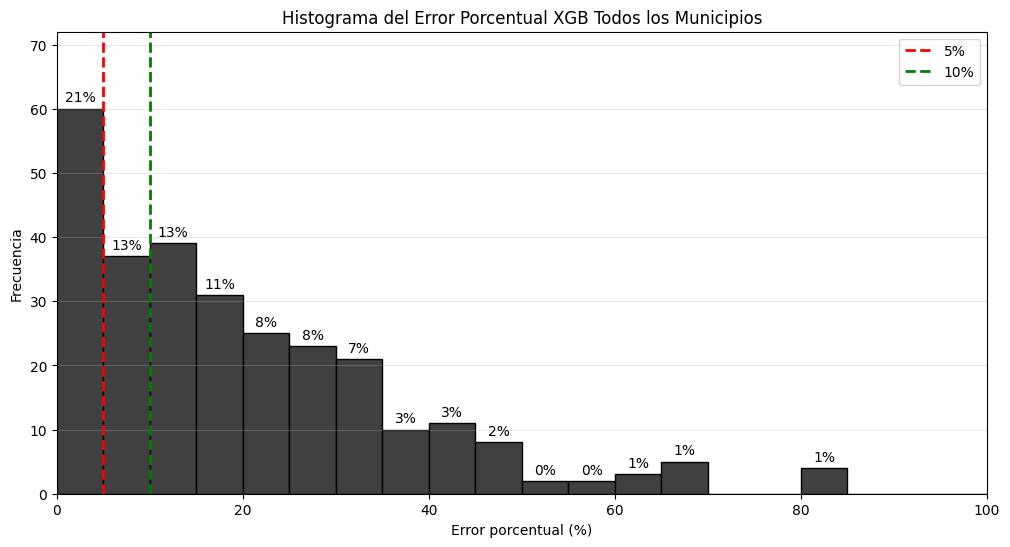

In [47]:
plt.figure(figsize=(12, 6))

# Rango de zoom

zoom_range = results_model_xgb["Error %"].clip(lower=0, upper=80)

# Bins de 5%

bins = np.arange(0, 105, 5)

# Histograma

counts, bins, patches = plt.hist(
    zoom_range,
    bins=bins,
    color="#404040",
    edgecolor="black"
)

plt.title("Histograma del Error Porcentual XGB Todos los Municipios")
plt.xlabel("Error porcentual (%)")
plt.ylabel("Frecuencia")
plt.grid(axis="y", alpha=0.3)

# Líneas verticales
plt.axvline(5, color="red", linestyle="--", linewidth=2, label="5%")
plt.axvline(10, color="green", linestyle="--", linewidth=2, label="10%")
plt.legend()

plt.xlim(0, 100)

# eje mas alejado

ymax = max(counts) * 1.20
plt.ylim(0, ymax)

# Porcentaje sobre cada barra sin decimales y con despegue

total = len(zoom_range)
offset = max(counts) * 0.01

for count, left_edge, right_edge in zip(counts, bins[:-1], bins[1:]):
    if count > 0:
        pct = int((count / total) * 100)
        x = (left_edge + right_edge) / 2
        y = count + offset
        plt.text(
            x,
            y,
            f"{pct}%",
            ha="center",
            va="bottom",
            fontsize=10
        )

plt.show()

### `xgb_ch`

In [48]:
from scipy import sparse

extra_cols = ["url"]

# Convertir sparse o dense a DataFrame float
if sparse.issparse(X_test_prep_ch):
    X_test_ch_dense = X_test_prep_ch.toarray()
else:
    X_test_ch_dense = X_test_prep_ch

X_test_ch_df = pd.DataFrame(X_test_ch_dense, dtype=float).reset_index(drop=True)

# Resetear y_test
y_test_ch_reset = y_test_ch.reset_index(drop=True)

# Filas originales del test
test_rows_ch = data_ch.loc[test_indices_ch].reset_index(drop=True)

# Evaluación
results_model_xgb_ch = evaluation_table(
    lgbm_ch,
    X_test_ch_df,
    y_test_ch_reset,
    test_rows_ch,
    extra_cols
)

results_model_xgb_ch.head(20)


,Precio Real,Precio Predicho,Error Absoluto,Error %,url
0,"238,000.00","616,005.59","378,005.59",158.83,https://www.casasymas.com.uy/propiedad/113804-...
1,"320,000.00","636,613.44","316,613.44",98.94,https://www.casasymas.com.uy/propiedad/211034-...
2,"1,620,000.00","596,856.04","1,023,143.96",63.16,https://www.casasymas.com.uy/propiedad/48875-c...
3,"1,500,000.00","685,928.20","814,071.80",54.27,https://www.casasymas.com.uy/propiedad/170824-...
4,"785,000.00","378,613.01","406,386.99",51.77,https://www.casasymas.com.uy/propiedad/184718-...
5,"185,000.00","271,494.61","86,494.61",46.75,https://www.casasymas.com.uy/propiedad/167907-...
6,"425,000.00","618,112.42","193,112.42",45.44,https://www.casasymas.com.uy/propiedad/202375-...
7,"1,350,000.00","787,052.22","562,947.78",41.70,https://www.casasymas.com.uy/propiedad/182809-...
8,"245,000.00","345,007.52","100,007.52",40.82,https://www.casasymas.com.uy/propiedad/192057-...
9,"495,000.00","295,827.37","199,172.63",40.24,https://www.casasymas.com.uy/propiedad/167515-...


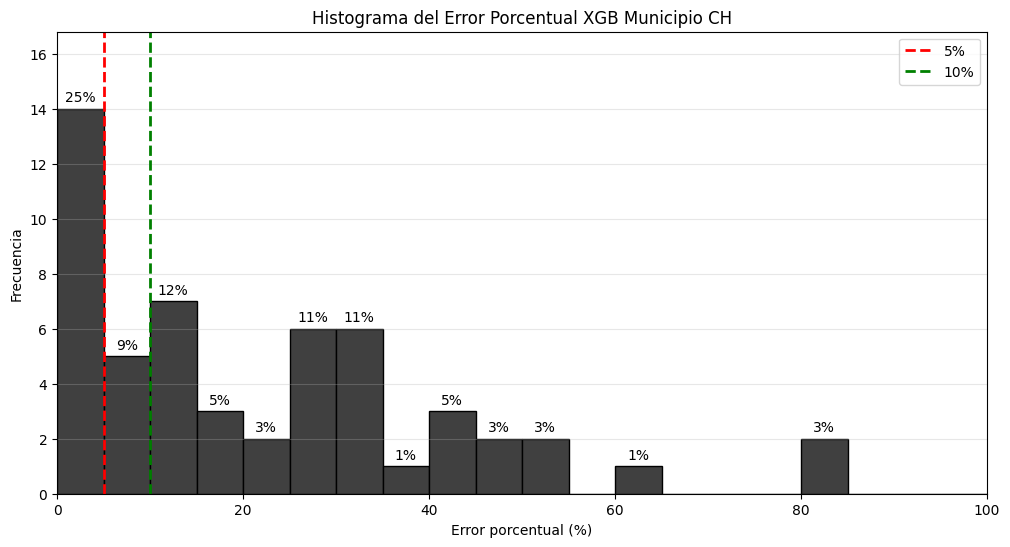

In [49]:
plt.figure(figsize=(12, 6))

# Rango de zoom
zoom_range = results_model_xgb_ch["Error %"].clip(lower=0, upper=80)

# Bins de 5%
bins = np.arange(0, 105, 5)

# Histograma
counts, bins, patches = plt.hist(
    zoom_range,
    bins=bins,
    color="#404040",
    edgecolor="black"
)

plt.title("Histograma del Error Porcentual XGB Municipio CH")
plt.xlabel("Error porcentual (%)")
plt.ylabel("Frecuencia")
plt.grid(axis="y", alpha=0.3)

# Líneas verticales
plt.axvline(5, color="red", linestyle="--", linewidth=2, label="5%")
plt.axvline(10, color="green", linestyle="--", linewidth=2, label="10%")
plt.legend()

plt.xlim(0, 100)

# eje mas alejado

ymax = max(counts) * 1.20
plt.ylim(0, ymax)

# Porcentaje sobre cada barra sin decimales y con despegue
total = len(zoom_range)
offset = max(counts) * 0.01

for count, left_edge, right_edge in zip(counts, bins[:-1], bins[1:]):
    if count > 0:
        pct = int((count / total) * 100)
        x = (left_edge + right_edge) / 2
        y = count + offset
        plt.text(
            x,
            y,
            f"{pct}%",
            ha="center",
            va="bottom",
            fontsize=10
        )

plt.show()

### `xgb_e`

In [50]:
results_model_xgb_e = evaluation_table(
    xgb_e,
    X_test_prep_e,
    y_test_e.values,
    data.loc[test_indices_e],
    extra_cols=["url"]
)

results_model_xgb_e.head(20)



,Precio Real,Precio Predicho,Error Absoluto,Error %,url
0,"180,000.00","594,820.38","414,820.38",230.46,https://www.casasymas.com.uy/propiedad/169029-...
1,"360,000.00","591,741.94","231,741.94",64.37,https://www.casasymas.com.uy/propiedad/191076-...
2,"650,000.00","1,064,334.25","414,334.25",63.74,https://www.casasymas.com.uy/propiedad/166354-...
3,"375,000.00","611,940.56","236,940.56",63.18,https://www.casasymas.com.uy/propiedad/208201-...
4,"135,000.00","208,470.11","73,470.11",54.42,https://www.casasymas.com.uy/propiedad/188669-...
5,"199,000.00","306,842.06","107,842.06",54.19,https://www.casasymas.com.uy/propiedad/194469-...
6,"370,000.00","564,693.56","194,693.56",52.62,https://www.casasymas.com.uy/propiedad/940-cas...
7,"360,000.00","530,566.56","170,566.56",47.38,https://www.casasymas.com.uy/propiedad/119722-...
8,"360,000.00","530,566.56","170,566.56",47.38,https://www.casasymas.com.uy/propiedad/203735-...
9,"850,000.00","1,230,984.62","380,984.63",44.82,https://www.casasymas.com.uy/propiedad/95141-c...


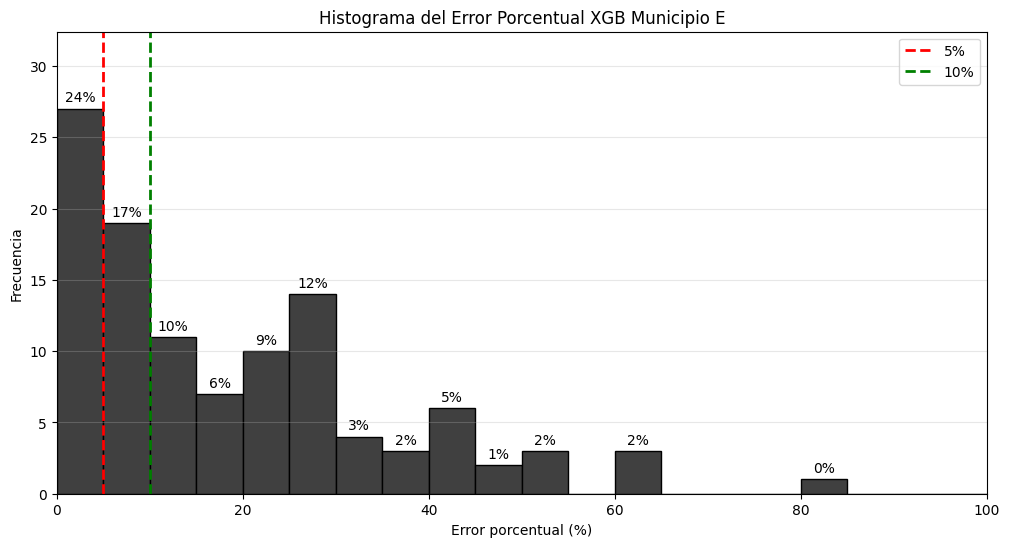

In [51]:
plt.figure(figsize=(12, 6))

# Rango de zoom
zoom_range = results_model_xgb_e["Error %"].clip(lower=0, upper=80)

# Bins de 5%
bins = np.arange(0, 105, 5)

# Histograma
counts, bins, patches = plt.hist(
    zoom_range,
    bins=bins,
    color="#404040",
    edgecolor="black"
)

plt.title("Histograma del Error Porcentual XGB Municipio E")
plt.xlabel("Error porcentual (%)")
plt.ylabel("Frecuencia")
plt.grid(axis="y", alpha=0.3)

# Líneas verticales
plt.axvline(5, color="red", linestyle="--", linewidth=2, label="5%")
plt.axvline(10, color="green", linestyle="--", linewidth=2, label="10%")
plt.legend()

plt.xlim(0, 100)

# eje mas alejado

ymax = max(counts) * 1.20
plt.ylim(0, ymax)

# Porcentaje sobre cada barra sin decimales y con despegue
total = len(zoom_range)
offset = max(counts) * 0.01

for count, left_edge, right_edge in zip(counts, bins[:-1], bins[1:]):
    if count > 0:
        pct = int((count / total) * 100)
        x = (left_edge + right_edge) / 2
        y = count + offset
        plt.text(
            x,
            y,
            f"{pct}%",
            ha="center",
            va="bottom",
            fontsize=10
        )

plt.show()

### `model_lgbm`

In [52]:
results_model_lgbm = evaluation_table(
    model_lgbm,
    X_test_prep_all_municipios,
    y_test_all_municipios.values,
    data.loc[test_indices_all_municipios],
    extra_cols=["url"]
)

results_model_lgbm.head(20)

,Precio Real,Precio Predicho,Error Absoluto,Error %,url
0,"238,000.00","575,391.47","337,391.47",141.76,https://www.casasymas.com.uy/propiedad/113804-...
1,"45,000.00","101,787.77","56,787.77",126.20,https://www.casasymas.com.uy/propiedad/151994-...
2,"137,900.00","295,096.71","157,196.71",113.99,https://www.casasymas.com.uy/propiedad/205556-...
3,"170,000.00","353,135.41","183,135.41",107.73,https://www.casasymas.com.uy/propiedad/206522-...
4,"43,000.00","79,230.61","36,230.61",84.26,https://www.casasymas.com.uy/propiedad/203258-...
5,"439,000.00","801,426.50","362,426.50",82.56,https://www.casasymas.com.uy/propiedad/74195-c...
6,"439,000.00","800,018.50","361,018.50",82.24,https://www.casasymas.com.uy/propiedad/74195-c...
7,"65,000.00","115,575.78","50,575.78",77.81,https://www.casasymas.com.uy/propiedad/188981-...
8,"92,000.00","162,670.30","70,670.30",76.82,https://www.casasymas.com.uy/propiedad/223818-...
9,"200,000.00","344,967.42","144,967.42",72.48,https://www.casasymas.com.uy/propiedad/227205-...


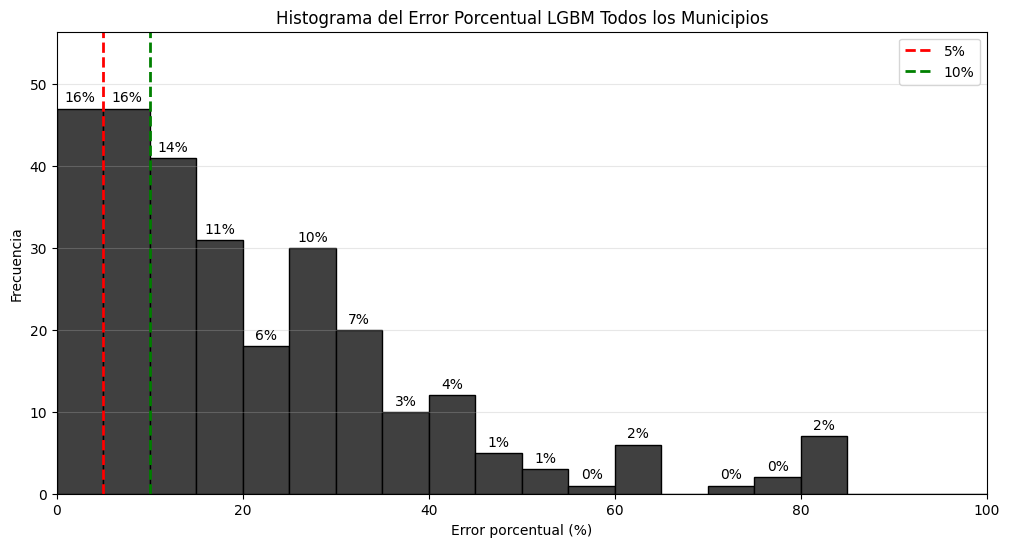

In [53]:
plt.figure(figsize=(12, 6))

# Rango de zoom
zoom_range = results_model_lgbm["Error %"].clip(lower=0, upper=80)

# Bins de 5%
bins = np.arange(0, 105, 5)

# Histograma
counts, bins, patches = plt.hist(
    zoom_range,
    bins=bins,
    color="#404040",
    edgecolor="black"
)

plt.title("Histograma del Error Porcentual LGBM Todos los Municipios")
plt.xlabel("Error porcentual (%)")
plt.ylabel("Frecuencia")
plt.grid(axis="y", alpha=0.3)

# Líneas verticales
plt.axvline(5, color="red", linestyle="--", linewidth=2, label="5%")
plt.axvline(10, color="green", linestyle="--", linewidth=2, label="10%")
plt.legend()

plt.xlim(0, 100)

# eje mas alejado

ymax = max(counts) * 1.20
plt.ylim(0, ymax)

# Porcentaje sobre cada barra sin decimales y con despegue
total = len(zoom_range)
offset = max(counts) * 0.01

for count, left_edge, right_edge in zip(counts, bins[:-1], bins[1:]):
    if count > 0:
        pct = int((count / total) * 100)
        x = (left_edge + right_edge) / 2
        y = count + offset
        plt.text(
            x,
            y,
            f"{pct}%",
            ha="center",
            va="bottom",
            fontsize=10
        )

plt.show()

### `lgbm_ch`

In [54]:
results_model_lgbm_ch = evaluation_table(
    lgbm_ch,
    X_test_prep_ch,
    y_test_ch.values,
    data.loc[test_indices_ch],
    extra_cols=["url"]
)

results_model_lgbm_ch.head(20)

,Precio Real,Precio Predicho,Error Absoluto,Error %,url
0,"238,000.00","616,005.59","378,005.59",158.83,https://www.casasymas.com.uy/propiedad/113804-...
1,"320,000.00","636,613.44","316,613.44",98.94,https://www.casasymas.com.uy/propiedad/211034-...
2,"1,620,000.00","596,856.04","1,023,143.96",63.16,https://www.casasymas.com.uy/propiedad/48875-c...
3,"1,500,000.00","685,928.20","814,071.80",54.27,https://www.casasymas.com.uy/propiedad/170824-...
4,"785,000.00","378,613.01","406,386.99",51.77,https://www.casasymas.com.uy/propiedad/184718-...
5,"185,000.00","271,494.61","86,494.61",46.75,https://www.casasymas.com.uy/propiedad/167907-...
6,"425,000.00","618,112.42","193,112.42",45.44,https://www.casasymas.com.uy/propiedad/202375-...
7,"1,350,000.00","787,052.22","562,947.78",41.70,https://www.casasymas.com.uy/propiedad/182809-...
8,"245,000.00","345,007.52","100,007.52",40.82,https://www.casasymas.com.uy/propiedad/192057-...
9,"495,000.00","295,827.37","199,172.63",40.24,https://www.casasymas.com.uy/propiedad/167515-...


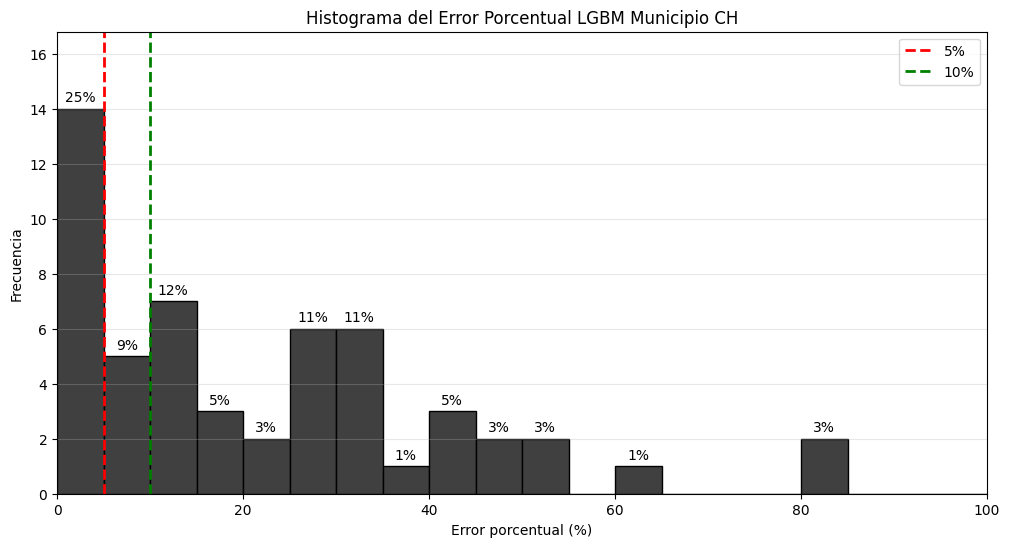

In [55]:
plt.figure(figsize=(12, 6))

# Rango de zoom
zoom_range = results_model_lgbm_ch["Error %"].clip(lower=0, upper=80)

# Bins de 5%
bins = np.arange(0, 105, 5)

# Histograma
counts, bins, patches = plt.hist(
    zoom_range,
    bins=bins,
    color="#404040",
    edgecolor="black"
)

plt.title("Histograma del Error Porcentual LGBM Municipio CH")
plt.xlabel("Error porcentual (%)")
plt.ylabel("Frecuencia")
plt.grid(axis="y", alpha=0.3)

# Líneas verticales
plt.axvline(5, color="red", linestyle="--", linewidth=2, label="5%")
plt.axvline(10, color="green", linestyle="--", linewidth=2, label="10%")
plt.legend()

plt.xlim(0, 100)

# eje mas alejado

ymax = max(counts) * 1.20
plt.ylim(0, ymax)

# Porcentaje sobre cada barra sin decimales y con despegue
total = len(zoom_range)
offset = max(counts) * 0.01

for count, left_edge, right_edge in zip(counts, bins[:-1], bins[1:]):
    if count > 0:
        pct = int((count / total) * 100)
        x = (left_edge + right_edge) / 2
        y = count + offset
        plt.text(
            x,
            y,
            f"{pct}%",
            ha="center",
            va="bottom",
            fontsize=10
        )

plt.show()

### `lgbm_e`

In [56]:
results_model_lgbm_e = evaluation_table(
    lgbm_e,
    X_test_prep_e,
    y_test_e.values,
    data.loc[test_indices_e],
    extra_cols=["url"]
)

results_model_lgbm_e.head(20)

,Precio Real,Precio Predicho,Error Absoluto,Error %,url
0,"180,000.00","628,105.52","448,105.52",248.95,https://www.casasymas.com.uy/propiedad/169029-...
1,"360,000.00","615,690.92","255,690.92",71.03,https://www.casasymas.com.uy/propiedad/191076-...
2,"280,000.00","477,717.11","197,717.11",70.61,https://www.casasymas.com.uy/propiedad/221704-...
3,"395,000.00","666,034.62","271,034.62",68.62,https://www.casasymas.com.uy/propiedad/207514-...
4,"115,000.00","191,599.47","76,599.47",66.61,https://www.casasymas.com.uy/propiedad/224989-...
5,"375,000.00","602,024.52","227,024.52",60.54,https://www.casasymas.com.uy/propiedad/208201-...
6,"370,000.00","578,276.75","208,276.75",56.29,https://www.casasymas.com.uy/propiedad/940-cas...
7,"129,000.00","199,052.61","70,052.61",54.30,https://www.casasymas.com.uy/propiedad/159112-...
8,"135,000.00","207,646.91","72,646.91",53.81,https://www.casasymas.com.uy/propiedad/188669-...
9,"480,000.00","730,613.29","250,613.29",52.21,https://www.casasymas.com.uy/propiedad/131012-...


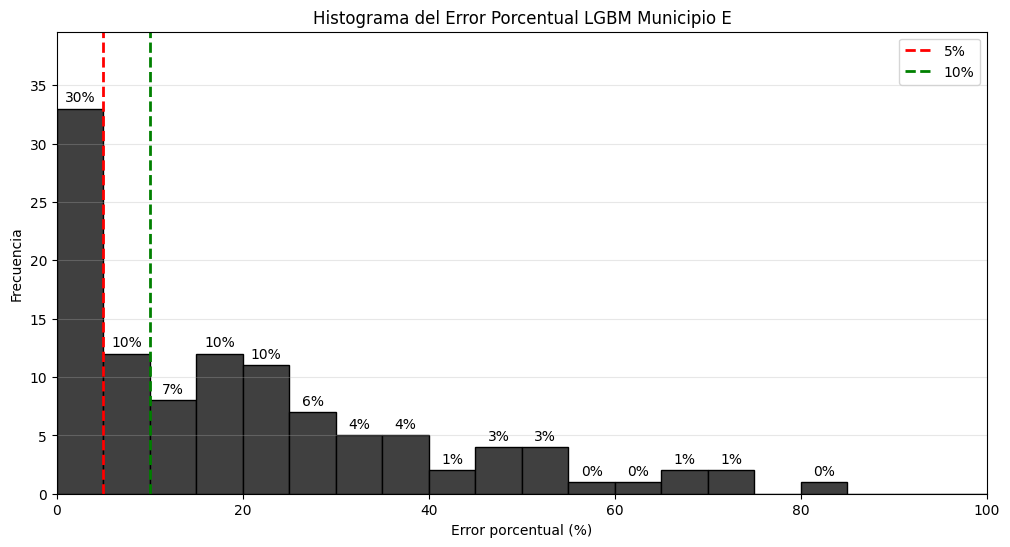

In [57]:
plt.figure(figsize=(12, 6))

# Rango de zoom
zoom_range = results_model_lgbm_e["Error %"].clip(lower=0, upper=80)

# Bins de 5%
bins = np.arange(0, 105, 5)

# Histograma
counts, bins, patches = plt.hist(
    zoom_range,
    bins=bins,
    color="#404040",
    edgecolor="black"
)

plt.title("Histograma del Error Porcentual LGBM Municipio E")
plt.xlabel("Error porcentual (%)")
plt.ylabel("Frecuencia")
plt.grid(axis="y", alpha=0.3)

# Líneas verticales
plt.axvline(5, color="red", linestyle="--", linewidth=2, label="5%")
plt.axvline(10, color="green", linestyle="--", linewidth=2, label="10%")
plt.legend()

plt.xlim(0, 100)

# eje mas alejado

ymax = max(counts) * 1.20
plt.ylim(0, ymax)

# Porcentaje sobre cada barra sin decimales y con despegue
total = len(zoom_range)
offset = max(counts) * 0.01

for count, left_edge, right_edge in zip(counts, bins[:-1], bins[1:]):
    if count > 0:
        pct = int((count / total) * 100)
        x = (left_edge + right_edge) / 2
        y = count + offset
        plt.text(
            x,
            y,
            f"{pct}%",
            ha="center",
            va="bottom",
            fontsize=10
        )

plt.show()

### `model_lr`

In [58]:
results_model_lr = evaluation_table(
    model_lr,
    X_test_prep_all_municipios,
    y_test_all_municipios.values,
    data.loc[test_indices_all_municipios],
    extra_cols=["url"]
)

results_model_lr.head(20)

,Precio Real,Precio Predicho,Error Absoluto,Error %,url
0,"137,900.00","467,742.24","329,842.24",239.19,https://www.casasymas.com.uy/propiedad/205556-...
1,"170,000.00","422,639.85","252,639.85",148.61,https://www.casasymas.com.uy/propiedad/206522-...
2,"238,000.00","468,576.08","230,576.08",96.88,https://www.casasymas.com.uy/propiedad/113804-...
3,"90,000.00","175,488.45","85,488.45",94.99,https://www.casasymas.com.uy/propiedad/123306-...
4,"440,000.00","840,426.99","400,426.99",91.01,https://www.casasymas.com.uy/propiedad/198708-...
5,"395,000.00","710,457.10","315,457.10",79.86,https://www.casasymas.com.uy/propiedad/207514-...
6,"270,000.00","479,216.18","209,216.18",77.49,https://www.casasymas.com.uy/propiedad/129839-...
7,"360,000.00","611,109.28","251,109.28",69.75,https://www.casasymas.com.uy/propiedad/191076-...
8,"45,000.00","74,491.79","29,491.79",65.54,https://www.casasymas.com.uy/propiedad/151994-...
9,"1,800,000.00","685,635.28","1,114,364.72",61.91,https://www.casasymas.com.uy/propiedad/63219-c...


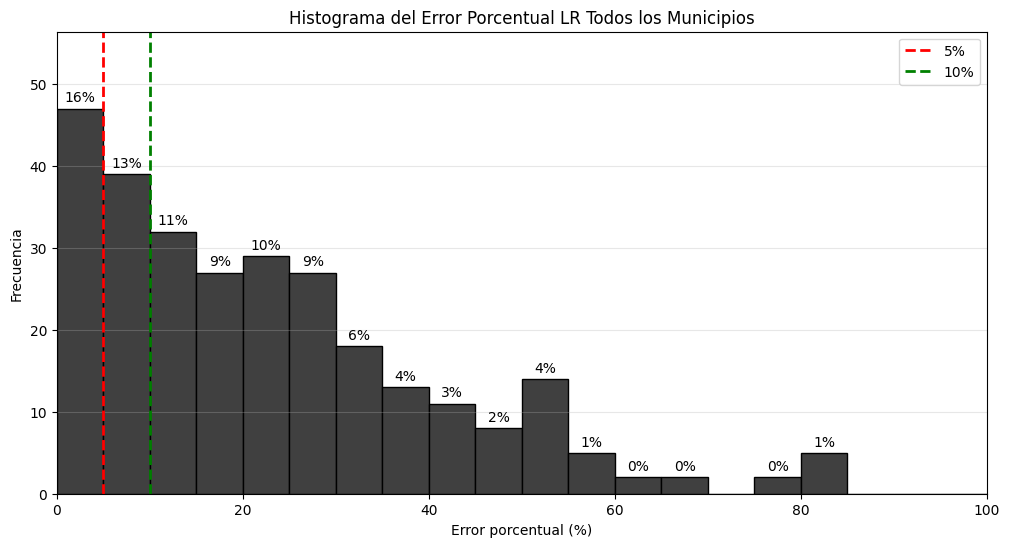

In [59]:
plt.figure(figsize=(12, 6))

# Rango de zoom
zoom_range = results_model_lr["Error %"].clip(lower=0, upper=80)

# Bins de 5%
bins = np.arange(0, 105, 5)

# Histograma
counts, bins, patches = plt.hist(
    zoom_range,
    bins=bins,
    color="#404040",
    edgecolor="black"
)

plt.title("Histograma del Error Porcentual LR Todos los Municipios")
plt.xlabel("Error porcentual (%)")
plt.ylabel("Frecuencia")
plt.grid(axis="y", alpha=0.3)

# Líneas verticales
plt.axvline(5, color="red", linestyle="--", linewidth=2, label="5%")
plt.axvline(10, color="green", linestyle="--", linewidth=2, label="10%")
plt.legend()

plt.xlim(0, 100)

# eje mas alejado

ymax = max(counts) * 1.20
plt.ylim(0, ymax)

# Porcentaje sobre cada barra sin decimales y con despegue
total = len(zoom_range)
offset = max(counts) * 0.01

for count, left_edge, right_edge in zip(counts, bins[:-1], bins[1:]):
    if count > 0:
        pct = int((count / total) * 100)
        x = (left_edge + right_edge) / 2
        y = count + offset
        plt.text(
            x,
            y,
            f"{pct}%",
            ha="center",
            va="bottom",
            fontsize=10
        )

plt.show()

### `model_lr_ch`

In [60]:
results_model_lr_ch = evaluation_table(
    model_lr_ch,
    X_test_prep_ch,
    y_test_ch.values,
    data.loc[test_indices_ch],
    extra_cols=["url"]
)

results_model_lr_ch.head(20)

,Precio Real,Precio Predicho,Error Absoluto,Error %,url
0,"320,000.00","555,228.66","235,228.66",73.51,https://www.casasymas.com.uy/propiedad/211034-...
1,"238,000.00","392,413.41","154,413.41",64.88,https://www.casasymas.com.uy/propiedad/113804-...
2,"420,000.00","638,575.83","218,575.83",52.04,https://www.casasymas.com.uy/propiedad/38319-c...
3,"130,000.00","188,304.13","58,304.13",44.85,https://www.casasymas.com.uy/propiedad/203660-...
4,"405,000.00","585,252.22","180,252.22",44.51,https://www.casasymas.com.uy/propiedad/221984-...
5,"1,620,000.00","954,458.70","665,541.30",41.08,https://www.casasymas.com.uy/propiedad/48875-c...
6,"785,000.00","481,573.64","303,426.36",38.65,https://www.casasymas.com.uy/propiedad/184718-...
7,"1,350,000.00","848,004.79","501,995.21",37.18,https://www.casasymas.com.uy/propiedad/182809-...
8,"439,000.00","601,387.17","162,387.17",36.99,https://www.casasymas.com.uy/propiedad/74195-c...
9,"330,000.00","211,305.62","118,694.38",35.97,https://www.casasymas.com.uy/propiedad/200339-...


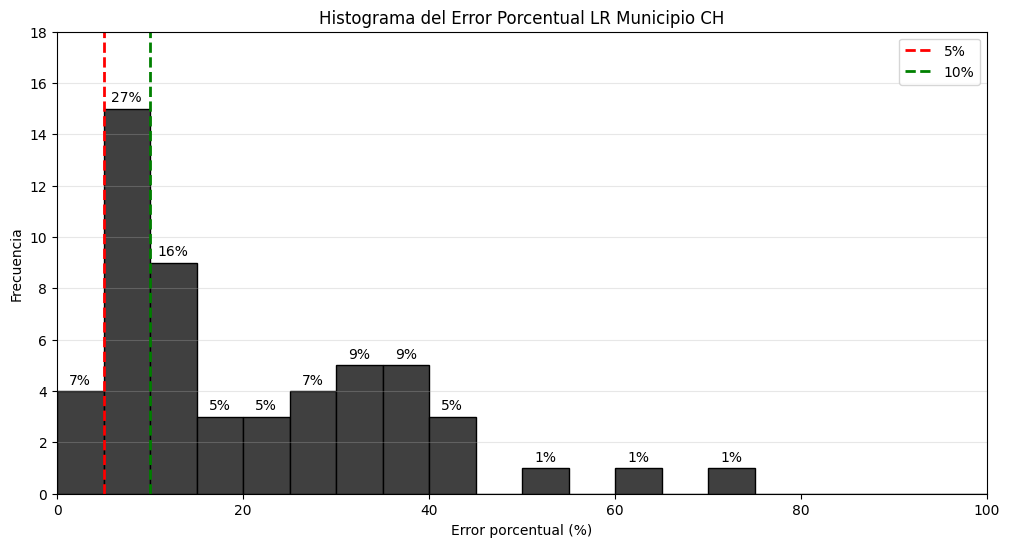

In [61]:
plt.figure(figsize=(12, 6))

# Rango de zoom
zoom_range = results_model_lr_ch["Error %"].clip(lower=0, upper=80)

# Bins de 5%
bins = np.arange(0, 105, 5)

# Histograma
counts, bins, patches = plt.hist(
    zoom_range,
    bins=bins,
    color="#404040",
    edgecolor="black"
)

plt.title("Histograma del Error Porcentual LR Municipio CH")
plt.xlabel("Error porcentual (%)")
plt.ylabel("Frecuencia")
plt.grid(axis="y", alpha=0.3)

# Líneas verticales
plt.axvline(5, color="red", linestyle="--", linewidth=2, label="5%")
plt.axvline(10, color="green", linestyle="--", linewidth=2, label="10%")
plt.legend()

plt.xlim(0, 100)

# eje mas alejado

ymax = max(counts) * 1.20
plt.ylim(0, ymax)

# Porcentaje sobre cada barra sin decimales y con despegue
total = len(zoom_range)
offset = max(counts) * 0.01

for count, left_edge, right_edge in zip(counts, bins[:-1], bins[1:]):
    if count > 0:
        pct = int((count / total) * 100)
        x = (left_edge + right_edge) / 2
        y = count + offset
        plt.text(
            x,
            y,
            f"{pct}%",
            ha="center",
            va="bottom",
            fontsize=10
        )

plt.show()

### `model_lr_e`

In [62]:
results_model_lr_e = evaluation_table(
    model_lr_e,
    X_test_prep_e,
    y_test_e.values,
    data.loc[test_indices_e],
    extra_cols=["url"]
)

results_model_lr_e.head(20)

,Precio Real,Precio Predicho,Error Absoluto,Error %,url
0,"180,000.00","526,900.01","346,900.01",192.72,https://www.casasymas.com.uy/propiedad/169029-...
1,"395,000.00","722,056.37","327,056.37",82.80,https://www.casasymas.com.uy/propiedad/207514-...
2,"135,000.00","237,762.21","102,762.21",76.12,https://www.casasymas.com.uy/propiedad/188669-...
3,"115,000.00","200,906.26","85,906.26",74.70,https://www.casasymas.com.uy/propiedad/224989-...
4,"360,000.00","628,383.76","268,383.76",74.55,https://www.casasymas.com.uy/propiedad/191076-...
5,"370,000.00","557,968.79","187,968.79",50.80,https://www.casasymas.com.uy/propiedad/940-cas...
6,"199,000.00","296,816.38","97,816.38",49.15,https://www.casasymas.com.uy/propiedad/194469-...
7,"280,000.00","416,821.56","136,821.56",48.86,https://www.casasymas.com.uy/propiedad/221704-...
8,"540,000.00","788,779.36","248,779.36",46.07,https://www.casasymas.com.uy/propiedad/205375-...
9,"235,000.00","341,476.05","106,476.05",45.31,https://www.casasymas.com.uy/propiedad/202567-...


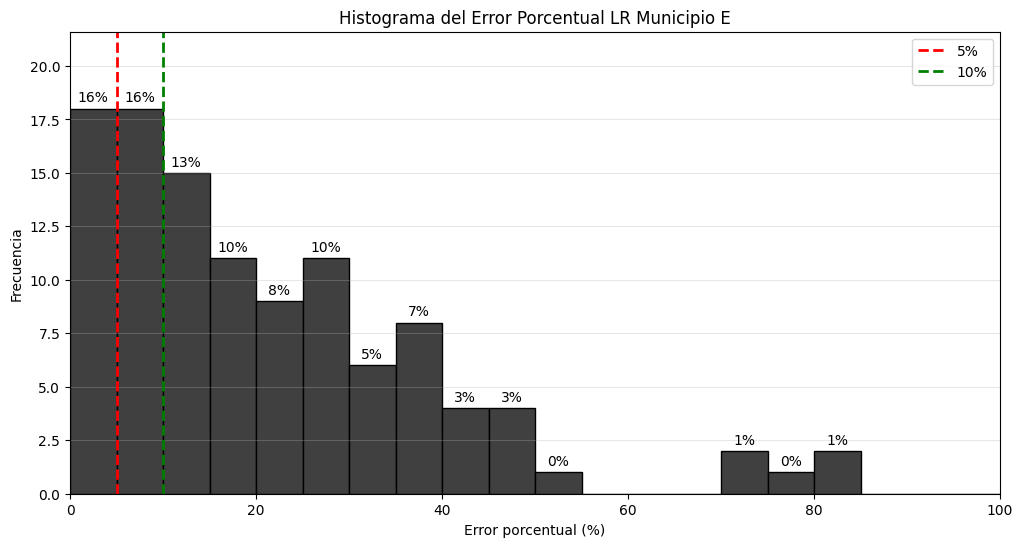

In [63]:
plt.figure(figsize=(12, 6))

# Rango de zoom
zoom_range = results_model_lr_e["Error %"].clip(lower=0, upper=80)

# Bins de 5%
bins = np.arange(0, 105, 5)

# Histograma
counts, bins, patches = plt.hist(
    zoom_range,
    bins=bins,
    color="#404040",
    edgecolor="black"
)

plt.title("Histograma del Error Porcentual LR Municipio E")
plt.xlabel("Error porcentual (%)")
plt.ylabel("Frecuencia")
plt.grid(axis="y", alpha=0.3)

# Líneas verticales
plt.axvline(5, color="red", linestyle="--", linewidth=2, label="5%")
plt.axvline(10, color="green", linestyle="--", linewidth=2, label="10%")
plt.legend()

plt.xlim(0, 100)

# eje mas alejado

ymax = max(counts) * 1.20
plt.ylim(0, ymax)

# Porcentaje sobre cada barra sin decimales y con despegue
total = len(zoom_range)
offset = max(counts) * 0.01

for count, left_edge, right_edge in zip(counts, bins[:-1], bins[1:]):
    if count > 0:
        pct = int((count / total) * 100)
        x = (left_edge + right_edge) / 2
        y = count + offset
        plt.text(
            x,
            y,
            f"{pct}%",
            ha="center",
            va="bottom",
            fontsize=10
        )

plt.show()

### `rf_all_municipios`

In [64]:
results_model_rf_all_municipios = evaluation_table(
    rf_all_municipios,
    X_test_prep_all_municipios,
    y_test_all_municipios.values,
    data.loc[test_indices_all_municipios],
    extra_cols=["url"]
)

results_model_rf_all_municipios.head(20)

,Precio Real,Precio Predicho,Error Absoluto,Error %,url
0,"45,000.00","109,542.89","64,542.89",143.43,https://www.casasymas.com.uy/propiedad/151994-...
1,"137,900.00","320,372.43","182,472.43",132.32,https://www.casasymas.com.uy/propiedad/205556-...
2,"43,000.00","89,464.19","46,464.19",108.06,https://www.casasymas.com.uy/propiedad/203258-...
3,"170,000.00","352,552.39","182,552.39",107.38,https://www.casasymas.com.uy/propiedad/206522-...
4,"58,905.00","115,636.44","56,731.44",96.31,https://www.casasymas.com.uy/propiedad/191802-...
5,"238,000.00","451,267.74","213,267.74",89.61,https://www.casasymas.com.uy/propiedad/113804-...
6,"75,000.00","136,615.74","61,615.74",82.15,https://www.casasymas.com.uy/propiedad/90139-c...
7,"90,000.00","161,550.67","71,550.67",79.50,https://www.casasymas.com.uy/propiedad/123306-...
8,"65,000.00","116,526.47","51,526.47",79.27,https://www.casasymas.com.uy/propiedad/188981-...
9,"90,000.00","155,439.29","65,439.29",72.71,https://www.casasymas.com.uy/propiedad/188212-...


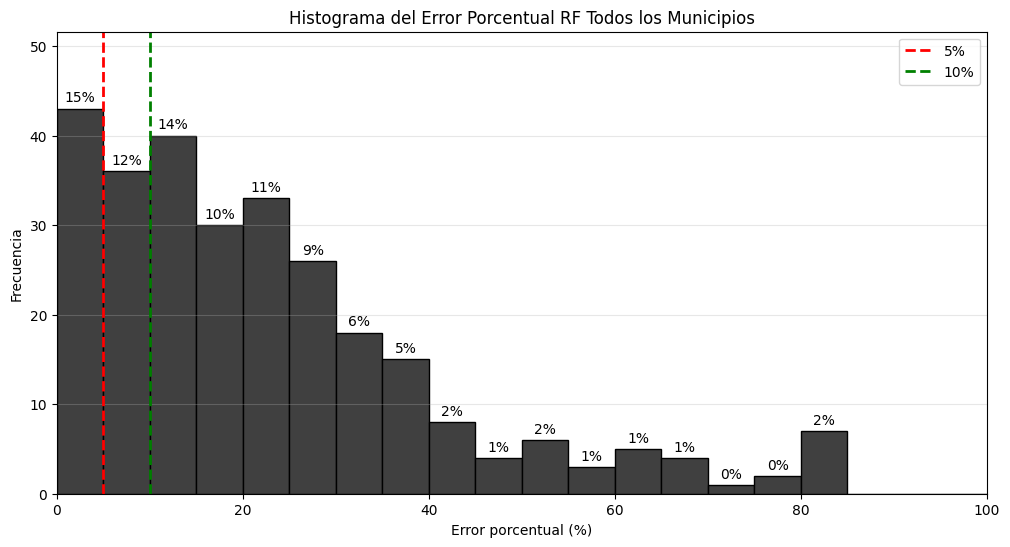

In [65]:
plt.figure(figsize=(12, 6))

# Rango de zoom
zoom_range = results_model_rf_all_municipios["Error %"].clip(lower=0, upper=80)

# Bins de 5%
bins = np.arange(0, 105, 5)

# Histograma
counts, bins, patches = plt.hist(
    zoom_range,
    bins=bins,
    color="#404040",
    edgecolor="black"
)

plt.title("Histograma del Error Porcentual RF Todos los Municipios")
plt.xlabel("Error porcentual (%)")
plt.ylabel("Frecuencia")
plt.grid(axis="y", alpha=0.3)

# Líneas verticales
plt.axvline(5, color="red", linestyle="--", linewidth=2, label="5%")
plt.axvline(10, color="green", linestyle="--", linewidth=2, label="10%")
plt.legend()

plt.xlim(0, 100)

# eje mas alejado

ymax = max(counts) * 1.20
plt.ylim(0, ymax)

# Porcentaje sobre cada barra sin decimales y con despegue
total = len(zoom_range)
offset = max(counts) * 0.01

for count, left_edge, right_edge in zip(counts, bins[:-1], bins[1:]):
    if count > 0:
        pct = int((count / total) * 100)
        x = (left_edge + right_edge) / 2
        y = count + offset
        plt.text(
            x,
            y,
            f"{pct}%",
            ha="center",
            va="bottom",
            fontsize=10
        )

plt.show()

### `rf_municipios_ch`

In [66]:
results_model_rf_municipio_ch = evaluation_table(
    rf_municipio_ch,
    X_test_prep_ch,
    y_test_ch.values,
    data.loc[test_indices_ch],
    extra_cols=["url"]
)

results_model_rf_municipio_ch.head(20)

,Precio Real,Precio Predicho,Error Absoluto,Error %,url
0,"238,000.00","531,955.04","293,955.04",123.51,https://www.casasymas.com.uy/propiedad/113804-...
1,"320,000.00","573,066.43","253,066.43",79.08,https://www.casasymas.com.uy/propiedad/211034-...
2,"1,620,000.00","596,220.88","1,023,779.12",63.20,https://www.casasymas.com.uy/propiedad/48875-c...
3,"1,500,000.00","742,751.90","757,248.10",50.48,https://www.casasymas.com.uy/propiedad/170824-...
4,"1,350,000.00","670,263.28","679,736.72",50.35,https://www.casasymas.com.uy/propiedad/182809-...
5,"185,000.00","263,346.87","78,346.87",42.35,https://www.casasymas.com.uy/propiedad/167907-...
6,"439,000.00","617,091.03","178,091.03",40.57,https://www.casasymas.com.uy/propiedad/74195-c...
7,"1,090,000.00","651,831.53","438,168.47",40.20,https://www.casasymas.com.uy/propiedad/111111-...
8,"179,000.00","248,894.38","69,894.38",39.05,https://www.casasymas.com.uy/propiedad/199371-...
9,"785,000.00","486,387.24","298,612.76",38.04,https://www.casasymas.com.uy/propiedad/184718-...


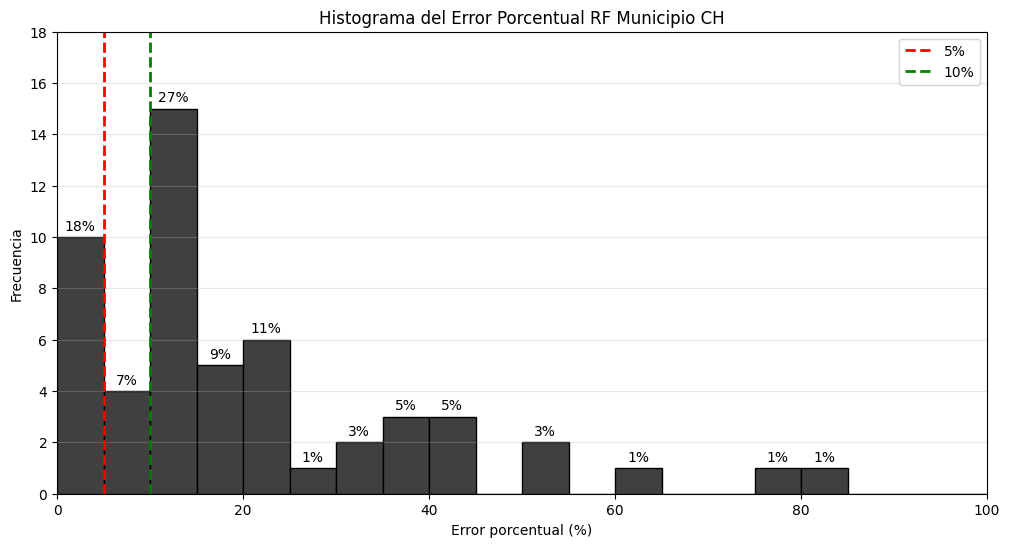

In [67]:
plt.figure(figsize=(12, 6))

# Rango de zoom
zoom_range = results_model_rf_municipio_ch["Error %"].clip(lower=0, upper=80)

# Bins de 5%
bins = np.arange(0, 105, 5)

# Histograma
counts, bins, patches = plt.hist(
    zoom_range,
    bins=bins,
    color="#404040",
    edgecolor="black"
)

plt.title("Histograma del Error Porcentual RF Municipio CH")
plt.xlabel("Error porcentual (%)")
plt.ylabel("Frecuencia")
plt.grid(axis="y", alpha=0.3)

# Líneas verticales
plt.axvline(5, color="red", linestyle="--", linewidth=2, label="5%")
plt.axvline(10, color="green", linestyle="--", linewidth=2, label="10%")
plt.legend()

plt.xlim(0, 100)

# eje mas alejado

ymax = max(counts) * 1.20
plt.ylim(0, ymax)

# Porcentaje sobre cada barra sin decimales y con despegue
total = len(zoom_range)
offset = max(counts) * 0.01

for count, left_edge, right_edge in zip(counts, bins[:-1], bins[1:]):
    if count > 0:
        pct = int((count / total) * 100)
        x = (left_edge + right_edge) / 2
        y = count + offset
        plt.text(
            x,
            y,
            f"{pct}%",
            ha="center",
            va="bottom",
            fontsize=10
        )

plt.show()

### `rf_municipio_e`

In [68]:
results_model_rf_municipio_e = evaluation_table(
    rf_municipio_e,
    X_test_prep_e,
    y_test_e.values,
    data.loc[test_indices_e],
    extra_cols=["url"]
)

results_model_rf_municipio_e.head(20)

,Precio Real,Precio Predicho,Error Absoluto,Error %,url
0,"180,000.00","592,603.60","412,603.60",229.22,https://www.casasymas.com.uy/propiedad/169029-...
1,"135,000.00","255,500.04","120,500.04",89.26,https://www.casasymas.com.uy/propiedad/188669-...
2,"115,000.00","197,464.20","82,464.20",71.71,https://www.casasymas.com.uy/propiedad/224989-...
3,"395,000.00","675,602.34","280,602.34",71.04,https://www.casasymas.com.uy/propiedad/207514-...
4,"360,000.00","604,663.20","244,663.20",67.96,https://www.casasymas.com.uy/propiedad/191076-...
5,"280,000.00","468,391.28","188,391.28",67.28,https://www.casasymas.com.uy/propiedad/221704-...
6,"129,000.00","210,384.77","81,384.77",63.09,https://www.casasymas.com.uy/propiedad/159112-...
7,"199,000.00","313,369.91","114,369.91",57.47,https://www.casasymas.com.uy/propiedad/194469-...
8,"375,000.00","563,274.67","188,274.67",50.21,https://www.casasymas.com.uy/propiedad/208201-...
9,"480,000.00","703,452.30","223,452.30",46.55,https://www.casasymas.com.uy/propiedad/131012-...


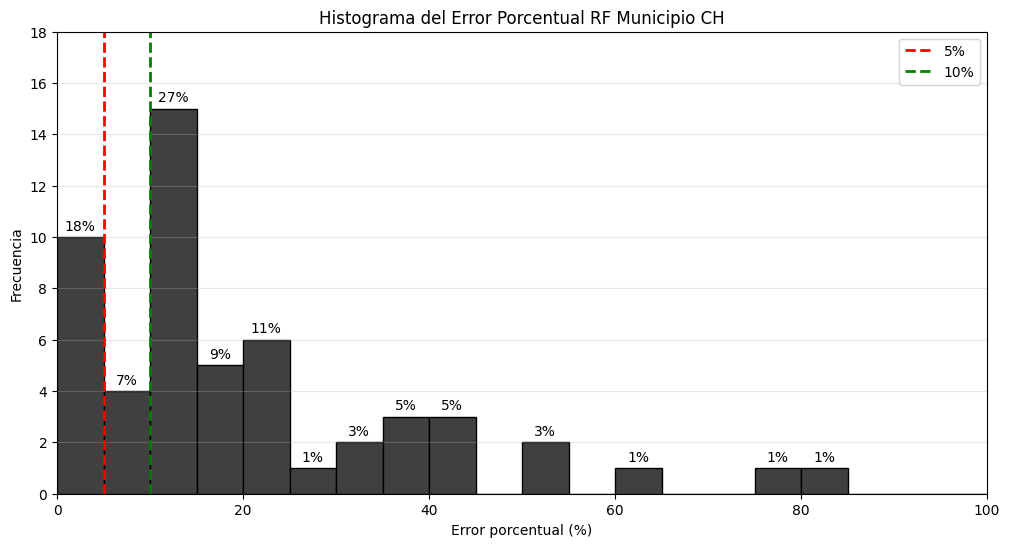

In [69]:
plt.figure(figsize=(12, 6))

# Rango de zoom
zoom_range = results_model_rf_municipio_ch["Error %"].clip(lower=0, upper=80)

# Bins de 5%
bins = np.arange(0, 105, 5)

# Histograma
counts, bins, patches = plt.hist(
    zoom_range,
    bins=bins,
    color="#404040",
    edgecolor="black"
)

plt.title("Histograma del Error Porcentual RF Municipio CH")
plt.xlabel("Error porcentual (%)")
plt.ylabel("Frecuencia")
plt.grid(axis="y", alpha=0.3)

# Líneas verticales
plt.axvline(5, color="red", linestyle="--", linewidth=2, label="5%")
plt.axvline(10, color="green", linestyle="--", linewidth=2, label="10%")
plt.legend()

plt.xlim(0, 100)

# eje mas alejado

ymax = max(counts) * 1.20
plt.ylim(0, ymax)

# Porcentaje sobre cada barra sin decimales y con despegue
total = len(zoom_range)
offset = max(counts) * 0.01

for count, left_edge, right_edge in zip(counts, bins[:-1], bins[1:]):
    if count > 0:
        pct = int((count / total) * 100)
        x = (left_edge + right_edge) / 2
        y = count + offset
        plt.text(
            x,
            y,
            f"{pct}%",
            ha="center",
            va="bottom",
            fontsize=10
        )

plt.show()